<a href="https://colab.research.google.com/github/xaldoxxx/BlockDeNotas/blob/main/apuestas004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

class Partido:
    id_counter = 1

    def __init__(self, local, visitante, resultado, fecha):
        self.id = Partido.id_counter
        Partido.id_counter += 1
        self.local = local
        self.visitante = visitante
        self.resultado = resultado
        self.fecha = fecha
    
    def guardar_csv(self, filename):
        data = {'ID': self.id, 'Fecha': self.fecha, 'EquipoLocal': self.local, 'EquipoVisitante': self.visitante, 'GLocal': self.resultado[0], 'GVisitante': self.resultado[1], 'Resultado': self.calcular_resultado(), 'Puntos': self.calcular_puntos()}
        df = pd.DataFrame([data])
        mode = 'w' if not os.path.exists(filename) else 'a'
        df.to_csv(filename, mode=mode, index=False, header=not os.path.exists(filename))

    def mostrar_info(self):
        print(f'ID: {self.id}')
        print(f'Local: {self.local}')
        print(f'Visitante: {self.visitante}')
        print(f'Resultado: {self.resultado}')
        print(f'Fecha: {self.fecha}')

    @staticmethod
    def inferir_fecha(element):
        soup = BeautifulSoup(element, 'html.parser')
        fecha_element = soup.find('span', class_='fecha')
        fecha = fecha_element.text.strip()
        fecha_inferida = fecha.split('-')[1].strip()
        return fecha_inferida

    def calcular_resultado(self):
        if self.resultado[0] > self.resultado[1]:
            return 1  # Gana equipo local
        elif self.resultado[0] < self.resultado[1]:
            return -1  # Gana equipo visitante
        else:
            return 0  # Empate

    def calcular_puntos(self):
        resultado = self.calcular_resultado()
        if resultado == 1:
            return 3  # Equipo local gana
        elif resultado == 0:
            return 1  # Empate
        else:
            return 0  # Equipo visitante gana

    @classmethod
    def crear_partidos(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        partidos_element = soup.find_all('li', class_='list-resultado')
        partidos = []
        for partido_element in partidos_element:
            local = partido_element.find('div', class_='equipo-local').find('span', class_='nombre-equipo').text.strip()
            visitante = partido_element.find('div', class_='equipo-visitante').find('span', class_='nombre-equipo').text.strip()
            resultado_element = partido_element.find('div', class_='cont-resultado').find('a', class_='resultado')
            resultado = resultado_element.text.strip() if resultado_element is not None else 'N/A'
            valores = re.findall(r'\d+', resultado)
            resultado_local = int(valores[0]) if valores else 0
            resultado_visitante = int(valores[1]) if len(valores) > 1 else 0
            fecha_element = partido_element.find('div', class_='info-evento').find('span', class_='fecha')
            fecha = cls.inferir_fecha(str(fecha_element))
            partido = cls(local, visitante, (resultado_local, resultado_visitante), fecha)
            partidos.append(partido)
        return partidos

# Obtener la página web
url_base = "https://argentina.as.com/resultados/futbol/argentina/2023/jornada/regular_a_"
partidos = []

# Iterar sobre las jornadas desde regular_a_1 hasta regular_a_16
for i in range(1, 19):
    url = url_base + str(i) + "/"
    partidos.extend(Partido.crear_partidos(url))

# Guardar en archivo CSV y mostrar información de los partidos
filename = 'partidos.csv'
for partido in partidos:
    partido.guardar_csv(filename)
    #partido.mostrar_info

# Separar partidos por equipo en dataframes individuales
equipo_partidos = {}
for partido in partidos:
    local = partido.local
    visitante = partido.visitante

    # Equipo local
    if local not in equipo_partidos:
        equipo_partidos[local] = []
    equipo_partidos[local].append(partido)

    # Equipo visitante
    if visitante not in equipo_partidos:
        equipo_partidos[visitante] = []
    equipo_partidos[visitante].append(partido)

# Crear un dataframe y guardar en un archivo CSV por cada equipo
for equipo, partidos_equipo in equipo_partidos.items():
    equipo_filename = equipo.lower().replace(' ', '_') + '.csv'
    equipo_df = pd.DataFrame({
        'ID': [partido.id for partido in partidos_equipo],
        'Fecha': [partido.fecha for partido in partidos_equipo],
        'EquipoLocal': [partido.local for partido in partidos_equipo],
        'EquipoVisitante': [partido.visitante for partido in partidos_equipo],
        'GLocal': [partido.resultado[0] for partido in partidos_equipo],
        'GVisitante': [partido.resultado[1] for partido in partidos_equipo],
        'GolesAFavor': [partido.resultado[0] if partido.local == equipo else partido.resultado[1] for partido in partidos_equipo],
        'GolesEnContra': [partido.resultado[1] if partido.local == equipo else partido.resultado[0] for partido in partidos_equipo],
        'Resultado': [partido.calcular_resultado() for partido in partidos_equipo],
        'Puntos': [partido.calcular_puntos() for partido in partidos_equipo]
    })
    equipo_df.to_csv(equipo_filename, index=False)


<h2> teniendo en cuenta la racha de los resultados </h2>

In [2]:
# con rsi
import pandas as pd

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def calculate_rsi(self):
        # Calcular el RSI (Relative Strength Index)
        df = self.dataframe.copy()
        df['Change'] = df['Resultado'].diff()
        df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
        df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)
        df['Avg Gain'] = df['Gain'].rolling(window=14).mean()
        df['Avg Loss'] = df['Loss'].rolling(window=14).mean()
        df['RS'] = df['Avg Gain'] / df['Avg Loss']
        df['RSI'] = 100 - (100 / (1 + df['RS']))

        return df['RSI'].iloc[-1]

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular el RSI para cada equipo
local_team_rsi = local_team.calculate_rsi()
visitor_team_rsi = visitor_team.calculate_rsi()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
if local_team_rsi > visitor_team_rsi:
    prediction = f'Gana {local_team.name}'
elif local_team_rsi < visitor_team_rsi:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Tigre


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv


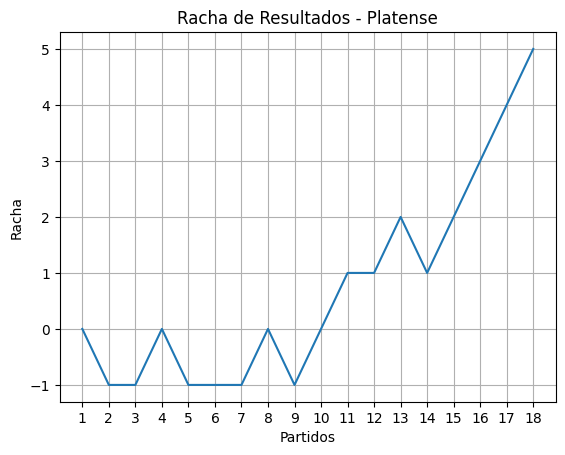

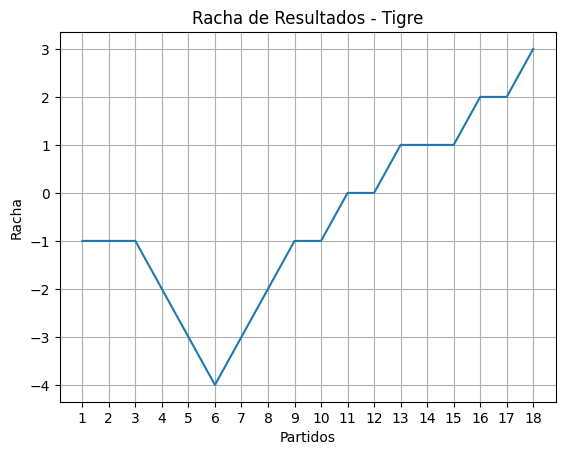


CUIDADO EL ALGORITMO FALLA Predicción para el partido entre Platense y Tigre: Empate


In [5]:
# este pedazo de codigo esta infiriendo de manera incorrecta los resultados

import pandas as pd
import matplotlib.pyplot as plt

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def plot_results_streak(self):
        results = self.dataframe['Resultado'].tolist()[:18]  # Obtener los primeros 18 resultados
        streak = [sum(results[:i+1]) for i in range(len(results))]  # Calcular la racha acumulada
        matches = list(range(1, len(results)+1))  # Número de partidos

        # Crear la gráfica de la racha de resultados
        plt.plot(matches, streak)
        plt.xlabel('Partidos')
        plt.ylabel('Racha')
        plt.title(f'Racha de Resultados - {self.name}')
        plt.xticks(matches)
        plt.grid(True)

        plt.show()

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team_name = local_team_csv.split('.')[0].capitalize()
visitor_team_name = visitor_team_csv.split('.')[0].capitalize()

local_team = Team(local_team_name, local_team_df)
visitor_team = Team(visitor_team_name, visitor_team_df)

# Graficar la racha de resultados del equipo local
local_team.plot_results_streak()

# Graficar la racha de resultados del equipo visitante
visitor_team.plot_results_streak()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
local_team_last_match = local_team_df.iloc[-1]
visitor_team_last_match = visitor_team_df.iloc[-1]

if local_team_last_match['Resultado'] > visitor_team_last_match['Resultado']:
    prediction = f'Gana {local_team.name}'
elif local_team_last_match['Resultado'] < visitor_team_last_match['Resultado']:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nCUIDADO EL ALGORITMO FALLA Predicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


In [6]:
import pandas as pd

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def get_result_sum(self):
        return self.dataframe['Resultado'].sum()

    @classmethod
    def from_csv(cls, csv_file):
        name = csv_file.split('.')[0].capitalize()
        dataframe = pd.read_csv(csv_file)
        return cls(name, dataframe)

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Crear objetos Team a partir de los archivos CSV
local_team = Team.from_csv(local_team_csv)
visitor_team = Team.from_csv(visitor_team_csv)

# Obtener la suma de los resultados para cada equipo
local_team_result_sum = local_team.get_result_sum()
visitor_team_result_sum = visitor_team.get_result_sum()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
if local_team_result_sum > visitor_team_result_sum:
    prediction = f'Gana {local_team.name}'
elif local_team_result_sum < visitor_team_result_sum:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Platense


In [7]:
#  algoritmo rsi teniendo en cuenta las columnas GolesAFavor y GolesEnContra de cada dataframe para predecir el resultado
import pandas as pd

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def calculate_rsi(self):
        # Calcular el RSI (Relative Strength Index) basado en Goles a Favor y Goles en Contra
        df = self.dataframe.copy()
        df['Change GF'] = df['GolesAFavor'].diff()
        df['Change GC'] = df['GolesEnContra'].diff()
        df['Gain'] = df['Change GF'].apply(lambda x: x if x > 0 else 0) + df['Change GC'].apply(lambda x: x if x > 0 else 0)
        df['Loss'] = abs(df['Change GF'].apply(lambda x: x if x < 0 else 0) + df['Change GC'].apply(lambda x: x if x < 0 else 0))
        df['Avg Gain'] = df['Gain'].rolling(window=14).mean()
        df['Avg Loss'] = df['Loss'].rolling(window=14).mean()
        df['RS'] = df['Avg Gain'] / df['Avg Loss']
        df['RSI'] = 100 - (100 / (1 + df['RS']))

        return df['RSI'].iloc[-1]

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular el RSI para cada equipo
local_team_rsi = local_team.calculate_rsi()
visitor_team_rsi = visitor_team.calculate_rsi()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
if local_team_rsi > visitor_team_rsi:
    prediction = f'Gana {local_team.name}'
elif local_team_rsi < visitor_team_rsi:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Tigre


In [8]:
import pandas as pd

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def calculate_rsi(self):
        # Obtener la suma de Goles a Favor y Goles en Contra
        goles_a_favor_sum = self.dataframe['GolesAFavor'].sum()
        goles_en_contra_sum = self.dataframe['GolesEnContra'].sum()

        # Calcular el RSI (Relative Strength Index) basado en la suma de Goles a Favor y Goles en Contra
        total_sum = goles_a_favor_sum + goles_en_contra_sum
        rsi = goles_a_favor_sum / total_sum * 100

        return rsi

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular el RSI para cada equipo
local_team_rsi = local_team.calculate_rsi()
visitor_team_rsi = visitor_team.calculate_rsi()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
if local_team_rsi > visitor_team_rsi:
    prediction = f'Gana {local_team.name}'
elif local_team_rsi < visitor_team_rsi:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Tigre


In [18]:
import pandas as pd

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def calculate_rsi(self):
        # Obtener la media de Goles a Favor y la suma de Goles en Contra
        goles_a_favor_mean = self.dataframe['GolesAFavor'].mean()
        goles_en_contra_sum = self.dataframe['GolesEnContra'].sum()

        # Calcular el RSI (Relative Strength Index) basado en la media de Goles a Favor y la suma de Goles en Contra
        rsi = goles_a_favor_mean / goles_en_contra_sum

        return rsi

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular el RSI para cada equipo
local_team_rsi = local_team.calculate_rsi()
visitor_team_rsi = visitor_team.calculate_rsi()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
if local_team_rsi > visitor_team_rsi:
    prediction = f'Gana {local_team.name}'
elif local_team_rsi < visitor_team_rsi:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Tigre


In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def train_regression_model(self):
        # Obtener las características (X) y la variable objetivo (y)
        X = self.dataframe[['GolesAFavor', 'GolesEnContra']]
        y = self.dataframe['Resultado']

        # Crear y entrenar el modelo de regresión lineal
        model = LinearRegression()
        model.fit(X, y)

        return model

    def predict_result(self, model, goles_a_favor_mean, goles_en_contra_sum):
        # Preparar los datos de entrada para hacer la predicción
        input_data = [[goles_a_favor_mean, goles_en_contra_sum]]

        # Realizar la predicción utilizando el modelo entrenado
        prediction = model.predict(input_data)[0]

        return prediction

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular la media de Goles a Favor y la suma de Goles en Contra para cada equipo
local_team_goles_a_favor_mean = local_team.dataframe['GolesAFavor'].mean()
local_team_goles_en_contra_sum = local_team.dataframe['GolesEnContra'].sum()

visitor_team_goles_a_favor_mean = visitor_team.dataframe['GolesAFavor'].mean()
visitor_team_goles_en_contra_sum = visitor_team.dataframe['GolesEnContra'].sum()

# Entrenar el modelo de regresión lineal para cada equipo
local_team_model = local_team.train_regression_model()
visitor_team_model = visitor_team.train_regression_model()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
local_team_prediction = local_team.predict_result(local_team_model, local_team_goles_a_favor_mean, local_team_goles_en_contra_sum)
visitor_team_prediction = visitor_team.predict_result(visitor_team_model, visitor_team_goles_a_favor_mean, visitor_team_goles_en_contra_sum)

if local_team_prediction > visitor_team_prediction:
    prediction = f'Gana {local_team.name}'
elif local_team_prediction < visitor_team_prediction:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Gana Tigre


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [21]:
# redes neuronnales multicapa
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def train_neural_network(self):
        # Obtener las características (X) y la variable objetivo (y)
        X = self.dataframe[['GolesAFavor', 'GolesEnContra']]
        y = self.dataframe['Resultado']

        # Crear y entrenar la red neuronal
        model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=2000)
        model.fit(X, y)

        return model

    def predict_result(self, model, goles_a_favor_mean, goles_en_contra_sum):
        # Preparar los datos de entrada para hacer la predicción
        input_data = np.array([[goles_a_favor_mean, goles_en_contra_sum]])

        # Realizar la predicción utilizando la red neuronal
        prediction = model.predict(input_data)[0]

        return prediction

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team = Team(local_team_csv.split('.')[0].capitalize(), local_team_df)
visitor_team = Team(visitor_team_csv.split('.')[0].capitalize(), visitor_team_df)

# Calcular la media de Goles a Favor y la suma de Goles en Contra para cada equipo
local_team_goles_a_favor_mean = local_team.dataframe['GolesAFavor'].mean()
local_team_goles_en_contra_sum = local_team.dataframe['GolesEnContra'].sum()

visitor_team_goles_a_favor_mean = visitor_team.dataframe['GolesAFavor'].mean()
visitor_team_goles_en_contra_sum = visitor_team.dataframe['GolesEnContra'].sum()

# Entrenar la red neuronal para cada equipo
local_team_model = local_team.train_neural_network()
visitor_team_model = visitor_team.train_neural_network()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
local_team_prediction = local_team.predict_result(local_team_model, local_team_goles_a_favor_mean, local_team_goles_en_contra_sum)
visitor_team_prediction = visitor_team.predict_result(visitor_team_model, visitor_team_goles_a_favor_mean, visitor_team_goles_en_contra_sum)

if local_team_prediction > visitor_team_prediction:
    prediction = f'Gana {local_team.name}'
elif local_team_prediction < visitor_team_prediction:
    prediction = f'Gana {visitor_team.name}'
else:
    prediction = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {prediction}')
# faltan datos necesita mas datos por eso el error

Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Empate


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [23]:
#  algoritmo de Máquinas de Vectores de Soporte de Regresión (SVR) teniendo en 
# cuenta la media, el promedio y la suma de las columnas "GolesAFavor" y 
# "GolesEnContra" de cada dataframe para predecir el resultado:
import pandas as pd
from sklearn.svm import SVR

class Team:
    def __init__(self, name, dataframe):
        self.name = name
        self.dataframe = dataframe

    def get_features(self):
        goals_for_mean = self.dataframe['GolesAFavor'].mean()
        goals_against_mean = self.dataframe['GolesEnContra'].mean()

        return [goals_for_mean, goals_against_mean]

    def train_model(self):
        X = self.dataframe[['GolesAFavor', 'GolesEnContra']]
        y = self.dataframe['Resultado']

        model = SVR()
        model.fit(X, y)

        return model

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Crear objetos Team
local_team_name = local_team_csv.split('.')[0].capitalize()
visitor_team_name = visitor_team_csv.split('.')[0].capitalize()

local_team = Team(local_team_name, local_team_df)
visitor_team = Team(visitor_team_name, visitor_team_df)

# Obtener las características de cada equipo
local_team_features = local_team.get_features()
visitor_team_features = visitor_team.get_features()

# Entrenar el modelo para cada equipo
local_team_model = local_team.train_model()
visitor_team_model = visitor_team.train_model()

# Predecir el resultado del partido entre el equipo local y el equipo visitante
prediction = local_team_model.predict([visitor_team_features])
prediction = round(prediction[0])  # Redondear la predicción a un resultado válido

if prediction > 0:
    result = f'Gana {local_team.name}'
elif prediction < 0:
    result = f'Gana {visitor_team.name}'
else:
    result = 'Empate'

print(f'\nPredicción para el partido entre {local_team.name} y {visitor_team.name}: {result}')



Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv

Predicción para el partido entre Platense y Tigre: Empate


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [30]:
# algoritmo genetico
import random
import pandas as pd

class Team:
    def __init__(self, name, goals_for_mean, goals_against_sum):
        self.name = name
        self.goals_for_mean = goals_for_mean
        self.goals_against_sum = goals_against_sum

class GeneticAlgorithm:
    def __init__(self, local_team, visitor_team):
        self.local_team = local_team
        self.visitor_team = visitor_team

    def fitness_function(self, team):
        goals_for_mean_diff = abs(self.local_team.goals_for_mean - team.goals_for_mean)
        goals_against_sum_diff = abs(self.local_team.goals_against_sum - team.goals_against_sum)
        fitness = 1 / (goals_for_mean_diff + goals_against_sum_diff)
        return fitness

    def crossover(self, parent1, parent2):
        crossover_point = random.randint(0, 1)
        if crossover_point == 0:
            child_goals_for_mean = parent1.goals_for_mean
            child_goals_against_sum = parent2.goals_against_sum
        else:
            child_goals_for_mean = parent2.goals_for_mean
            child_goals_against_sum = parent1.goals_against_sum
        child = Team("Child", child_goals_for_mean, child_goals_against_sum)
        return child

    def mutation(self, team):
        mutation_rate = 0.1
        mutation_amount = 0.1
        if random.random() < mutation_rate:
            team.goals_for_mean += random.uniform(-mutation_amount, mutation_amount)
            team.goals_against_sum += random.uniform(-mutation_amount, mutation_amount)
        return team

    def selection(self, population, fitness_scores):
        tournament_size = 3
        selected_parents = []
        for _ in range(len(population)):
            tournament_contestants = random.choices(population, k=tournament_size)
            tournament_scores = [fitness_scores[population.index(contestant)] for contestant in tournament_contestants]
            winner = tournament_contestants[tournament_scores.index(max(tournament_scores))]
            selected_parents.append(winner)
        return selected_parents

    def evolve(self, generations, population_size):
        population = [self.create_random_team() for _ in range(population_size)]

        for _ in range(generations):
            fitness_scores = [self.fitness_function(team) for team in population]

            selected_parents = self.selection(population, fitness_scores)

            new_population = []
            for i in range(population_size):
                parent1 = random.choice(selected_parents)
                parent2 = random.choice(selected_parents)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                new_population.append(child)

            population = new_population

        best_team = max(population, key=self.fitness_function)
        return best_team

    def create_random_team(self):
        goals_for_mean = random.uniform(0, 10)
        goals_against_sum = random.uniform(0, 10)
        return Team("Random Team", goals_for_mean, goals_against_sum)

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_df = pd.read_csv(local_team_csv)
visitor_team_df = pd.read_csv(visitor_team_csv)

# Obtener los valores de media y suma de GolesAFavor y GolesEnContra para cada equipo
local_goals_for_mean = local_team_df['GolesAFavor'].mean()
local_goals_against_sum = local_team_df['GolesEnContra'].sum()
visitor_goals_for_mean = visitor_team_df['GolesAFavor'].mean()
visitor_goals_against_sum = visitor_team_df['GolesEnContra'].sum()

# Crear los objetos de equipo para el algoritmo genético
local_team = Team("Local Team", local_goals_for_mean, local_goals_against_sum)
visitor_team = Team("Visitor Team", visitor_goals_for_mean, visitor_goals_against_sum)

# Crear una instancia del algoritmo genético
genetic_algorithm = GeneticAlgorithm(local_team, visitor_team)

# Ejecutar el algoritmo genético para evolucionar y encontrar el mejor equipo
best_team = genetic_algorithm.evolve(generations=100, population_size=50)

# Imprimir el mejor equipo encontrado
print("Mejor equipo:")
print("Nombre:", best_team.name)
print("Media de goles a favor:", best_team.goals_for_mean)
print("Suma de goles en contra:", best_team.goals_against_sum)



Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv
Mejor equipo:
Nombre: Child
Media de goles a favor: 1.1117787321541388
Suma de goles en contra: 12.313343453591512


In [32]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class IntelligentAlgorithm:
    def __init__(self, local_team_data, visitor_team_data):
        self.local_team_data = local_team_data
        self.visitor_team_data = visitor_team_data
        self.model = None

    def preprocess_data(self, data):
        # Preprocesar los datos para el modelo
        processed_data = data[['GolesAFavor', 'GolesEnContra']]
        return processed_data

    def train_model(self):
        # Preprocesar los datos de los equipos locales y visitantes
        local_team_processed_data = self.preprocess_data(self.local_team_data)
        visitor_team_processed_data = self.preprocess_data(self.visitor_team_data)

        # Crear los datos de entrenamiento combinando los equipos locales y visitantes
        X = pd.concat([local_team_processed_data, visitor_team_processed_data])
        y = [1] * len(local_team_processed_data) + [0] * len(visitor_team_processed_data)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenar el modelo de regresión logística
        self.model = LogisticRegression()
        self.model.fit(X_train, y_train)

        # Evaluar la precisión del modelo en el conjunto de prueba
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Precisión del modelo: {accuracy}")

    def predict_result(self):
        if self.model is None:
            print("Entrena el modelo antes de hacer predicciones.")
            return

        # Preprocesar los datos del equipo local
        local_team_processed_data = self.preprocess_data(self.local_team_data)

        # Predecir el resultado del partido
        result = self.model.predict(local_team_processed_data)

        if result[0] == 1:
            return "Se espera que el equipo local gane el partido."
        else:
            return "Se espera que el equipo visitante gane el partido."

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_data = pd.read_csv(local_team_csv)
visitor_team_data = pd.read_csv(visitor_team_csv)

# Crear una instancia del algoritmo de IA
intelligent_algorithm = IntelligentAlgorithm(local_team_data, visitor_team_data)

# Entrenar el modelo
intelligent_algorithm.train_model()

# Predecir el resultado del partido
prediction = intelligent_algorithm.predict_result()

# Imprimir la predicción
print(prediction)



Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv
Precisión del modelo: 0.5
Se espera que el equipo local gane el partido.


In [33]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class IntelligentAlgorithm:
    def __init__(self, local_team_data, visitor_team_data):
        self.local_team_data = local_team_data
        self.visitor_team_data = visitor_team_data
        self.model = None

    def preprocess_data(self, data):
        # Preprocesar los datos para el modelo
        processed_data = data[['GolesAFavor', 'GolesEnContra']]
        return processed_data

    def train_model(self):
        # Preprocesar los datos de los equipos locales y visitantes
        local_team_processed_data = self.preprocess_data(self.local_team_data)
        visitor_team_processed_data = self.preprocess_data(self.visitor_team_data)

        # Crear los datos de entrenamiento combinando los equipos locales y visitantes
        X = pd.concat([local_team_processed_data, visitor_team_processed_data])
        y = [1] * len(local_team_processed_data) + [0] * len(visitor_team_processed_data)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenar el modelo de árbol de decisión
        self.model = DecisionTreeClassifier()
        self.model.fit(X_train, y_train)

        # Evaluar la precisión del modelo en el conjunto de prueba
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Precisión del modelo: {accuracy}")

    def predict_result(self):
        if self.model is None:
            print("Entrena el modelo antes de hacer predicciones.")
            return

        # Preprocesar los datos del equipo local
        local_team_processed_data = self.preprocess_data(self.local_team_data)

        # Predecir el resultado del partido
        result = self.model.predict(local_team_processed_data)

        if result[0] == 1:
            return "Se espera que el equipo local gane el partido."
        else:
            return "Se espera que el equipo visitante gane el partido."

# Solicitar los nombres de los archivos CSV de los equipos locales y visitantes
local_team_csv = input("Ingrese el nombre del archivo CSV del equipo local: ")
visitor_team_csv = input("Ingrese el nombre del archivo CSV del equipo visitante: ")

# Cargar los datos de los archivos CSV
local_team_data = pd.read_csv(local_team_csv)
visitor_team_data = pd.read_csv(visitor_team_csv)

# Crear una instancia del algoritmo de IA
intelligent_algorithm = IntelligentAlgorithm(local_team_data, visitor_team_data)

# Entrenar el modelo
intelligent_algorithm.train_model()

# Predecir el resultado del partido
prediction = intelligent_algorithm.predict_result()

# Imprimir la predicción
print(prediction)


Ingrese el nombre del archivo CSV del equipo local: platense.csv
Ingrese el nombre del archivo CSV del equipo visitante: tigre.csv
Precisión del modelo: 0.375
Se espera que el equipo visitante gane el partido.
